# Lab 3: Context

In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from diffusion_utilities import *

/home/kaushik/miniconda3/envs/py3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting Things Up

In [2]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat: context features
        super(ContextUnet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  # assume h == w. Must be divisible by 4

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels=in_channels, out_channels=n_feat, is_res=True)

        # Initialize the downsampling path of the U-net with two levels
        self.down1 = UnetDown(in_channels=n_feat, out_channels=n_feat)    # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(in_channels=n_feat, out_channels=2*n_feat)  # down2 #[10, 256, 4,  4]

        self.to_vec = nn.Sequential(nn.AvgPool2d(4), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(input_dim=1, emb_dim=2*n_feat)
        self.timeembed2 = EmbedFC(input_dim=1, emb_dim=1*n_feat)
        self.contextembed1 = EmbedFC(input_dim=n_cfeat, emb_dim=2*n_feat)
        self.contextembed2 = EmbedFC(input_dim=n_cfeat, emb_dim=1*n_feat)

        # Initialize the upsampling path of the U-net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2*n_feat, out_channels=2*n_feat, kernel_size=self.h//4, stride=self.h//4),  # up-sample
            nn.GroupNorm(num_groups=8, num_channels=2*n_feat),  # normalize
            nn.ReLU()
        )
        self.up1 = UnetUp(in_channels=4*n_feat, out_channels=n_feat)
        self.up2 = UnetUp(in_channels=2*n_feat, out_channels=n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(in_channels=2*n_feat, out_channels=n_feat, kernel_size=3, stride=1, padding=1),  # reduce number of feature maps
            nn.GroupNorm(num_groups=8, num_channels=n_feat),  # normalize
            nn.ReLU(),
            nn.Conv2d(in_channels=n_feat, out_channels=self.in_channels, kernel_size=3, stride=1, padding=1)
        )
    
    def forward(self, x, t, c=None):
        """
        x: (batch, n_feat, h, w): input image
        t: (batch, n_cfeat)     : time step
        c: (batch, n_classes)   : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on
        
        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       # [10, 256, 8, 8]
        down2 = self.down2(down1)   # [10, 256, 4, 4]

        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)
        
        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))

        return out


In [3]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device("cpu"))
n_feat = 64  # hidden dimension feature
n_cfeat = 5  # context vector
height = 16  # 16x16 image
save_dir = "./weights/"

# training hyperparameters
batch_size = 100
n_epoch = 32
lrate = 1e-3

In [4]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(start=0, end=1, steps=timesteps+1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1

In [5]:
# construct model
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [6]:
device

device(type='cuda', index=0)

## Context

In [6]:
# reset neural network
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

# re setup optimizer
optim = torch.optim.Adam(params=nn_model.parameters(), lr=lrate)

KA: The following two cells seem to be missing in the Jupyter notebook shared in the course.

In [7]:
# load dataset and construct optimizer
dataset = CustomDataset(sfilename="./data/sprites_1788_16x16.npy", lfilename="./data/sprite_labels_nc_1788_16x16.npy", transform=transform, null_context=False)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=1)
optim = torch.optim.Adam(params=nn_model.parameters(), lr=lrate)

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [8]:
# helper function: Perturbs an image to a specified noise level
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]) * noise

In [11]:
# training with context code

# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f"epoch {ep}")

    # linearly decay learning rate
    optim.param_groups[0]["lr"] = lrate * (1 - ep/n_epoch)

    pbar = tqdm(dataloader, mininterval=2)
    for x, c in pbar:  # x: images  c: context
        optim.zero_grad()
        x = x.to(device)
        c = c.to(x)

        # randomly maskout c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device=device)
        c = c * context_mask.unsqueeze(-1)

        # perturb data
        noise = torch.randn_like(x)
        t = torch.randint(low=1, high=timesteps+1, size=(x.shape[0],)).to(device)
        x_pert = perturb_input(x, t, noise)

        # use network to recover noise
        pred_noise = nn_model(x=x_pert, t=t/timesteps, c=c)

        # loas is mean squared error between the predicted and true noise
        loss = F.mse_loss(input=pred_noise, target=noise)
        loss.backward()

        optim.step()
    
    # save model periodically
    if ep % 4 == 0 or ep == int(n_epoch - 1):
        if not os.path.exists(save_dir):
            os.makedir(save_dir)
        
        torch.save(nn_model.state_dict(), save_dir + f"context_model_{ep}.pth")
        print("saved model at " + save_dir + f"context_model_{ep}.pth")

epoch 0


100%|██████████| 894/894 [00:19<00:00, 45.33it/s]


saved model at ./weights/context_model_0.pth
epoch 1


100%|██████████| 894/894 [00:19<00:00, 46.37it/s]


epoch 2


100%|██████████| 894/894 [00:19<00:00, 45.75it/s]


epoch 3


100%|██████████| 894/894 [00:19<00:00, 46.25it/s]


epoch 4


100%|██████████| 894/894 [00:19<00:00, 46.38it/s]


saved model at ./weights/context_model_4.pth
epoch 5


100%|██████████| 894/894 [00:19<00:00, 45.26it/s]


epoch 6


100%|██████████| 894/894 [00:20<00:00, 44.59it/s]


epoch 7


100%|██████████| 894/894 [00:20<00:00, 43.93it/s]


epoch 8


100%|██████████| 894/894 [00:20<00:00, 43.65it/s]


saved model at ./weights/context_model_8.pth
epoch 9


100%|██████████| 894/894 [00:20<00:00, 43.62it/s]


epoch 10


100%|██████████| 894/894 [00:21<00:00, 41.47it/s]


epoch 11


100%|██████████| 894/894 [00:21<00:00, 41.57it/s]


epoch 12


100%|██████████| 894/894 [00:21<00:00, 42.18it/s]


saved model at ./weights/context_model_12.pth
epoch 13


100%|██████████| 894/894 [00:21<00:00, 42.38it/s]


epoch 14


100%|██████████| 894/894 [00:21<00:00, 42.23it/s]


epoch 15


100%|██████████| 894/894 [00:21<00:00, 42.35it/s]


epoch 16


100%|██████████| 894/894 [00:20<00:00, 42.76it/s]


saved model at ./weights/context_model_16.pth
epoch 17


100%|██████████| 894/894 [00:21<00:00, 42.57it/s]


epoch 18


100%|██████████| 894/894 [1:30:01<00:00,  6.04s/it]


epoch 19


100%|██████████| 894/894 [00:48<00:00, 18.40it/s]


epoch 20


100%|██████████| 894/894 [00:42<00:00, 21.20it/s]


saved model at ./weights/context_model_20.pth
epoch 21


100%|██████████| 894/894 [00:27<00:00, 32.29it/s]


epoch 22


100%|██████████| 894/894 [00:28<00:00, 31.25it/s]


epoch 23


100%|██████████| 894/894 [00:26<00:00, 34.33it/s]


epoch 24


100%|██████████| 894/894 [00:27<00:00, 32.40it/s]


saved model at ./weights/context_model_24.pth
epoch 25


100%|██████████| 894/894 [00:34<00:00, 25.75it/s]


epoch 26


100%|██████████| 894/894 [00:29<00:00, 29.83it/s]


epoch 27


100%|██████████| 894/894 [00:26<00:00, 33.44it/s]


epoch 28


100%|██████████| 894/894 [00:28<00:00, 31.63it/s]


saved model at ./weights/context_model_28.pth
epoch 29


100%|██████████| 894/894 [00:19<00:00, 46.16it/s]


epoch 30


100%|██████████| 894/894 [00:19<00:00, 45.52it/s]


epoch 31


100%|██████████| 894/894 [00:19<00:00, 45.17it/s]

saved model at ./weights/context_model_31.pth


In [9]:
# load in pretrain model weights and set to eval mode
nn_model.load_state_dict(state_dict=torch.load(f=f"{save_dir}/context_model_trained.pth", map_location=device))
nn_model.eval()
print("Loaded in Context Model")

Loaded in Context Model


## Sampling with Context

In [10]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t])/(1 - ab_t[t]).sqrt())) / a_t[t].sqrt()

    return mean + noise

In [11]:
# sample with context using standard algorithm
@torch.no_grad()
def sample_ddpm_context(n_sample, context, save_rate=20):
    # x_T ~ N(0,1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device=device)

    # array to keep track of generated steps for plotting
    intermediate = []
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time sensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device=device)

        # sample some random noise to inject back in. For i=1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t, c=context)  # predict noise e_(x_t, t, ctx)
        samples = denoise_add_noise(x=samples, t=i, pred_noise=eps, z=z)
        if i % save_rate == 0 or i == timesteps or i < 8:
            intermediate.append(samples.detach().cpu().numpy())
    
    intermediate = np.stack(intermediate)

    return samples, intermediate
        

In [13]:
# visualize samples with randomly selected context
plt.clf()
ctx = F.one_hot(torch.randint(low=0, high=5, size=(32,)), num_classes=5).to(device=device).float()
samples, intermediate = sample_ddpm_context(n_sample=32, context=ctx)
animation_ddpm_context = plot_sample(x_gen_store=intermediate, n_sample=32, nrows=4, save_dir=save_dir, fn="ani_run", w=None, save=False)
HTML(animation_ddpm_context.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [14]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

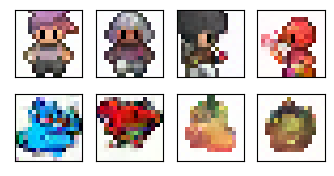

In [15]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],  
    [1,0,0,0,0],    
    [0,0,0,0,1],
    [0,0,0,0,1],    
    [0,1,0,0,0],
    [0,1,0,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

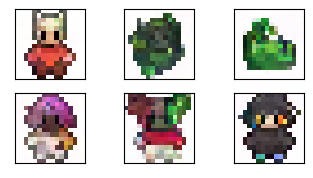

In [16]:
# mix of defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],      #human
    [1,0,0.6,0,0],    
    [0,0,0.6,0.4,0],  
    [1,0,0,0,1],  
    [1,1,0,0,0],
    [1,0,0,1,0]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

### Sampling with model trained at Epoch 31

In [17]:
# load in model weights and set to eval mode
ep = 31
nn_model.load_state_dict(state_dict=torch.load(f=f"{save_dir}/context_model_{ep}.pth", map_location=device))
nn_model.eval()
print("Loaded in Context Model")

Loaded in Context Model


In [18]:
# visualize samples with randomly selected context
plt.clf()
ctx = F.one_hot(torch.randint(low=0, high=5, size=(32,)), num_classes=5).to(device=device).float()
samples, intermediate = sample_ddpm_context(n_sample=32, context=ctx)
animation_ddpm_context = plot_sample(x_gen_store=intermediate, n_sample=32, nrows=4, save_dir=save_dir, fn="ani_run", w=None, save=False)
HTML(animation_ddpm_context.to_jshtml())

<Figure size 640x480 with 0 Axes>

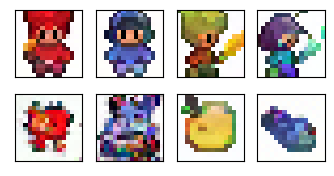

In [19]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],  
    [1,0,0,0,0],    
    [0,0,0,0,1],
    [0,0,0,0,1],    
    [0,1,0,0,0],
    [0,1,0,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

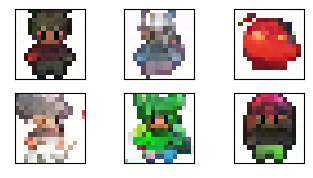

In [20]:
# mix of defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],      #human
    [1,0,0.6,0,0],    
    [0,0,0.6,0.4,0],  
    [1,0,0,0,1],  
    [1,1,0,0,0],
    [1,0,0,1,0]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

# Acknowledgments
Sprites by ElvGames, [FrootsnVeggies](https://zrghr.itch.io/froots-and-veggies-culinary-pixels) and  [kyrise](https://kyrise.itch.io/)   
This code is modified from, https://github.com/cloneofsimo/minDiffusion   
Diffusion model is based on [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) and [Denoising Diffusion Implicit Models](https://arxiv.org/abs/2010.02502)